In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from icedef import constants, iceberg, metocean, drift, tools, simulator, test_case, plot, timesteppers

In [2]:
tc = test_case.TestCase()
start_latitude = tc.start_latitude
start_longitude = tc.start_longitude
start_velocity = tc.start_velocity
start_time = tc.start_time
end_time = tc.end_time
ref_times = tc.ref_times
ref_lons = tc.ref_lons
ref_lats = tc.ref_lats
start_location = (tc.start_latitude, tc.start_longitude)
time_frame = (tc.start_time, tc.end_time)
start_velocity = tc.start_velocity

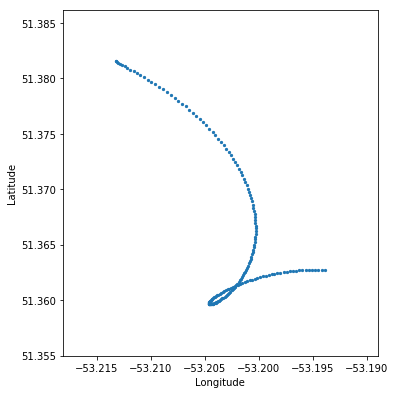

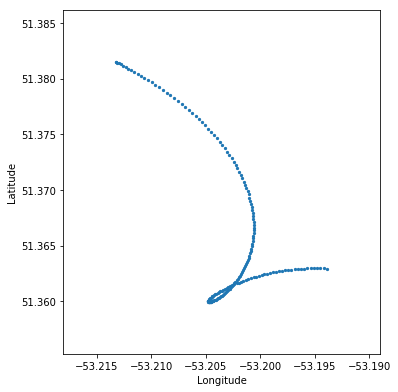

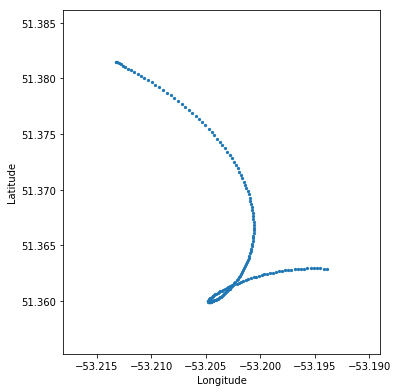

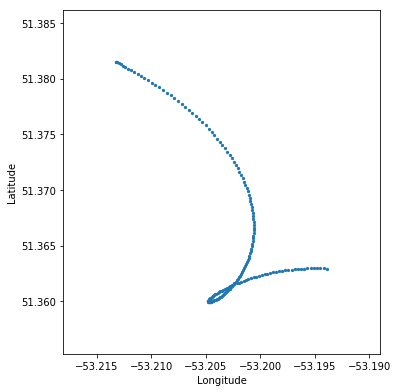

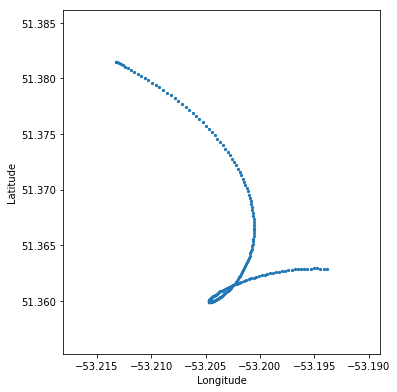

In [3]:
sim = simulator.Simulator()

sim.time_stepper = timesteppers.euler
sim.run_simulation(start_location, time_frame, store_results_as='euler')
plot.plot_iceberg_track(sim.results['euler']['latitude'], sim.results['euler']['longitude'])

sim.time_stepper = timesteppers.rk2
sim.run_simulation(start_location, time_frame, store_results_as='rk2')
plot.plot_iceberg_track(sim.results['rk2']['latitude'], sim.results['rk2']['longitude'])

sim.time_stepper = timesteppers.rk4
sim.run_simulation(start_location, time_frame, store_results_as='rk4')
plot.plot_iceberg_track(sim.results['rk4']['latitude'], sim.results['rk4']['longitude'])

sim.time_stepper = timesteppers.ab2
sim.run_simulation(start_location, time_frame, store_results_as='ab2')
plot.plot_iceberg_track(sim.results['ab2']['latitude'], sim.results['ab2']['longitude'])

sim.time_stepper = timesteppers.ab3
sim.run_simulation(start_location, time_frame, store_results_as='ab3')
plot.plot_iceberg_track(sim.results['ab3']['latitude'], sim.results['ab3']['longitude'])


# Optimization

In [4]:
from scipy import optimize

## Basinhopping

In [5]:
def sim_wrapper(x0, keys, start_location, time_frame, ref_latlons, **kwargs):
    
    print(x0)
    
    sim = simulator.Simulator()
    
    for i in range(len(x0)):
        
        kwargs[keys[i]] = x0[i]
        
    xds = sim.run_simulation(start_location, time_frame, **kwargs)
    
    mse = simulator.compute_mse((xds['latitude'], xds['longitude']), ref_latlons)
    
    return mse

In [6]:
class MyTakeStep(object):
    def __init__(self, stepsize=0.5):
        self.stepsize = stepsize
    def __call__(self, x):
        s = self.stepsize
        for i in range(len(x)):
            x[i] += np.random.uniform(0, s)
        return x
    
class MyBounds(object):
    def __init__(self, xmax=[1600, 600], xmin=[160, 60]):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs['x_new']
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax, tmin

In [7]:
x0 = 160, 60
keys = 'waterline_length', 'sail_height'
ref_latlons = ref_lats, ref_lons
args = keys, start_location, time_frame, ref_latlons
minimizer_kwargs = {'args': args}

In [8]:
optimization_result = optimize.basinhopping(sim_wrapper, x0, niter=10, interval=1,
                                            minimizer_kwargs=minimizer_kwargs, disp=True,
                                           take_step=MyTakeStep(100), accept_test=MyBounds())

[160.  60.]
[160.00000001  60.        ]
[160.          60.00000001]
[160.  60.]
basinhopping step 0: f 0.0117383
adaptive stepsize: acceptance rate 0.000000 target 0.500000 new stepsize 90 old stepsize 100
[246.75450443  94.27932278]
[246.75450444  94.27932278]
[246.75450443  94.2793228 ]
[246.75450443  94.27932278]
basinhopping step 1: f 0.0114967 trial_f 0.0114967 accepted 1  lowest_f 0.0114967
found new global minimum on step 1 with function value 0.0114967
adaptive stepsize: acceptance rate 0.500000 target 0.500000 new stepsize 81 old stepsize 90
[326.61984287 108.36108196]
[326.61984289 108.36108196]
[326.61984287 108.36108197]
[326.61984287 108.36108196]
basinhopping step 2: f 0.0116261 trial_f 0.0116261 accepted 1  lowest_f 0.0114967
adaptive stepsize: acceptance rate 0.666667 target 0.500000 new stepsize 90 old stepsize 81
[381.43907798 117.96266632]
[381.439078   117.96266632]
[381.43907798 117.96266634]
[381.43907798 117.96266632]
basinhopping step 3: f 0.0117771 trial_f 0.01

In [9]:
optimization_result

                        fun: 0.011496709258903061
 lowest_optimization_result:       fun: 0.011496709258903061
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([-2.63913535e-07,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([246.75450443,  94.27932278])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 44
                        nit: 10
                       njev: 11
                          x: array([246.75450443,  94.27932278])

## Differential Evolution

In [10]:
bounds = ((16, 1600), (6, 600))
optimization_result = optimize.differential_evolution(sim_wrapper, bounds, args)

[550.81184846  37.98867744]
[383.60803635 569.42418457]
[762.07450097 253.61842323]
[278.46380192 326.33080087]
[1464.10423155  304.41389347]
[1124.89817379  492.01856649]
[707.53313179 205.58056809]
[133.25674159 586.88601363]
[605.02484392 475.16714243]
[1259.55167362   99.0183594 ]
[1585.27469876  430.34601518]
[ 58.07348065 375.75525586]
[309.88972145  18.26860808]
[679.85983289 524.17241511]
[968.36090479  49.86452964]
[203.9345748  405.23185669]
[1037.21015148  272.71562791]
[535.08784601 137.90760913]
[1096.9186522   383.51555539]
[1192.14891573  344.79035659]
[950.72083056 501.42190069]
[1366.7535132   106.99507501]
[1327.93579651  449.33262603]
[485.40444236 234.28216416]
[1510.67040642  541.42315892]
[872.6966167  192.87159082]
[83.25632283 73.54898253]
[401.56008025 170.2047295 ]
[1403.47382541  291.22756418]
[829.38141135 162.33997775]
[278.46380192 464.87546297]
[238.14689781 569.42418457]
[762.07450097 342.48416626]
[977.53883865 499.15232388]
[622.94901343 561.9445758 ]


In [11]:
optimization_result

     fun: 0.0114940296499009
 message: 'Optimization terminated successfully.'
    nfev: 153
     nit: 4
 success: True
       x: array([238.14689781, 569.42418457])

# Fixing Quivers

In [14]:
import importlib

In [15]:
importlib.reload(plot)

<module 'icedef.plot' from '/home/evankielley/IceDEF/icedef/plot.py'>

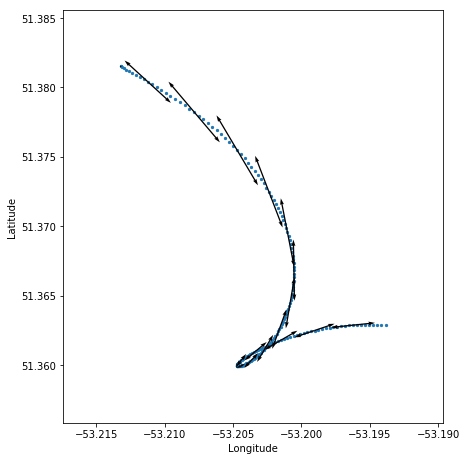

In [16]:
plot.plot_iceberg_track(sim.results['ab3']['latitude'], sim.results['ab3']['longitude'], 
    vectors=np.array([
    np.array([sim.results['ab3']['iceberg_eastward_velocity'].values, 
             sim.results['ab3']['iceberg_northward_velocity'].values]),
    np.array([sim.results['ab3']['iceberg_eastward_velocity'].values * -3, 
             sim.results['ab3']['iceberg_northward_velocity'].values * -3])
    ]), figure_scale_factor=1.2)

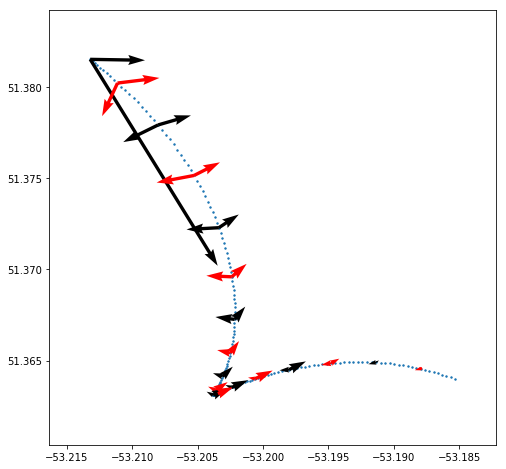

In [26]:
xds = simulator.run_test_simulation(start_location, time_frame)

gap = 10

X = np.array((xds['longitude'].values[::gap], xds['longitude'].values[::gap]))
Y = np.array((xds['latitude'].values[::gap], xds['latitude'].values[::gap]))
#X = xds['longitude'].values[::gap]
#Y = xds['latitude'].values[::gap]
U = np.array((xds['current_eastward_force'].values[::gap], xds['wind_eastward_force'].values[::gap]))
V = np.array((xds['current_northward_force'].values[::gap], xds['wind_northward_force'].values[::gap]))
C = ['black', 'red']

plt.figure(figsize=(8, 8))
plt.scatter(xds['longitude'], xds['latitude'], s=2)

plt.quiver(X, Y, U, V, color=C)

plt.show()

45997.21032165361


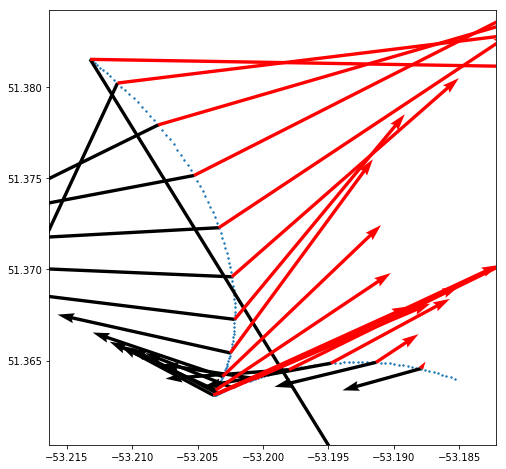

In [45]:
xds = simulator.run_test_simulation(start_location, time_frame)

gap = 10

X = xds['longitude'].values[::gap]
Y = xds['latitude'].values[::gap]
U = np.array((xds['current_eastward_force'].values[::gap], xds['wind_eastward_force'].values[::gap]))
V = np.array((xds['current_northward_force'].values[::gap], xds['wind_northward_force'].values[::gap]))
colors = ['black', 'red']

plt.figure(figsize=(8, 8))
plt.scatter(xds['longitude'], xds['latitude'], s=2)

norms = [np.linalg.norm(np.sqrt(u**2 + v**2)) for u, v in zip(u, v)]
mean_norm = np.mean(norms)
print(mean_norm)

for u, v, color in zip(U, V, colors):
    plt.quiver(X, Y, u, v, color=color, scale_units='xy', scale=mean_norm*50)

plt.show()